In [7]:
#dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
import joypy
sns.set()

#misc
import time
np.set_printoptions(suppress=True)



In [92]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'NotWindy.h5')

In [93]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

# ## getting the indexes for odor over a threshold to determine each encounter
# def get_index(df):
#     idx = []
#     for i in range(len(df.filtered_odor)):
#         if (df.filtered_odor[i]>4):
#             idx.append(df.index[i])

#     from itertools import groupby
#     from operator import itemgetter
#     index = [ ]
#     for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
#         index.append((list((map(itemgetter(1), g)))))
#     return index

def get_index(df):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>4):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [94]:
fdf=pd.DataFrame()
index = get_index(df)

#Distance

i = 0
avg_dist_source = []
while i<len(index):
    avg_dist_source.append(np.mean(df.distance_from_source[index[i]])) ## _ is declination corrected distance
    i+=1
fdf['avg_dist_from_source']=avg_dist_source

avg_dist_from_streakline = []

i = 0
while i<len(index):
    avg_dist_from_streakline.append(np.mean(df.nearest_from_streakline_[index[i]]))
    i+=1
fdf['avg_dist_from_streakline']=avg_dist_from_streakline

# RELATIVE MOTION

rel_parallel_enc = []
i= 0
while i<len(index):
    rel_parallel_enc.append(np.mean(df.relative_parallel_comp[index[i]]))
    i+=1
fdf['avg_parallel_encounter']=rel_parallel_enc


rel_perpendicular_enc = []
i= 0
while i<len(index):
    rel_perpendicular_enc.append(np.mean(df.relative_perpendicular_comp[index[i]]))
    i+=1
fdf['avg_perpendicular_encounter']=rel_perpendicular_enc


rel_parallel_inter = []
i= 0
while i < len(index):
    if i < (len(index)-1):
        rel_parallel_inter.append(np.mean(df.relative_parallel_comp[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        rel_parallel_inter.append(0)
        i+=1

fdf['avg_parallel_intermittency']=rel_parallel_inter

       
rel_perpendicular_inter = []
i= 0
while i < len(index):
    if i < (len(index)-1):
        rel_perpendicular_inter.append(np.mean(df.relative_perpendicular_comp[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        rel_perpendicular_inter.append(0)
        i+=1
        
fdf['avg_perpendicular_intermittency']=rel_perpendicular_inter

print('done')

done


In [95]:
# time of the encounters
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    length_of_encounter.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = length_of_encounter

#time between the encounters
i = 0
intermittency = []
while i < len(index):
    if i < (len(index)-1):
        intermittency.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        intermittency.append(0)
        i+=1
fdf['odor_intermittency'] = intermittency

## Trajectory speed during Intermittency
i = 0
speed_at_intermittency=[]
while i < len(index):
    if i < (len(index)-1):
        x = np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])
        y = np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]])
        z = np.mean(df.gps_linear_z[index[i][-1]:index[i+1][0]])
        speed_at_intermittency.append(np.sqrt(x**2+y**2+z**2))
        i+=1
    else:
        speed_at_intermittency.append(0)
        i+=1

fdf['speed_at_intermittency'] = speed_at_intermittency

## Trajectory speed during Encounters
i = 0
speed_at_encounter=[]
while i < len(index):
        x = np.mean(df.gps_linear_x[index[i]])
        y = np.mean(df.gps_linear_y[index[i]])
        z = np.mean(df.gps_linear_z[index[i]])
        speed_at_encounter.append(np.sqrt(x**2+y**2+z**2))
        i+=1
fdf['speed_at_encounter'] = speed_at_encounter

print('done')

done


In [96]:
# binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 2
kernel = exp_ker(t,tau)

filtered = signal.convolve(df.efreq, kernel, mode='same', method='auto')
df['encounter_frequency']=filtered

#Average Encounter Frequency
i = 0
wfreq = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    wfreq.append(np.mean(df.encounter_frequency[index[i]]))
    i+=1
fdf['mean_encounter_frequency'] = wfreq

In [98]:
# # Average Intermittency Factor
# window = np.lib.stride_tricks.sliding_window_view(df.index,1001)
# ifact=[]
# for i in range(len(window)):
#     ifact.append(np.count_nonzero(np.where(df.odor[window[i]]>4))/len(window[i]))

# lst = [0] * (len(df)-len(np.lib.stride_tricks.sliding_window_view(df.index,1001)))
# x = ifact + lst

# df['intermittency_fraction'] = x


# ## encounter frequency
# def exp_ker(t, tau):
#     return np.exp(-t/tau)/tau

# t = df.time[:8008]
# tau = 3
# kernel = exp_ker(t,tau)

# smoothed_if = signal.convolve(df.intermittency_fraction, kernel, mode='same', method='auto')
# df['intermittency_factor']=smoothed_if

# # len(th_occurence)

In [99]:
#Average Intermittency Factor
i = 0
ifr = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    ifr.append(np.mean(df.intermittency_factor[index[i]]))
    i+=1
fdf['mean_intermittency_factor'] = ifr

In [100]:
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# df.to_hdf(dir+'NotWindywithIF.h5', key='fdf', mode='w')

In [101]:
## Avg slope calculation
x=df.odor
y=df.time

params1 = [3, 1000, 200] ## Filter Design
x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params1)

In [102]:
i = 0
xhat = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    xhat.append(np.mean(x_hat[index[i]]))
    i+=1
fdf['estimated_odor_xhat'] = xhat

i = 0
dxdthat = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    dxdthat.append(np.mean(dxdt_hat[index[i]]))
    i+=1
fdf['odor_derivative'] = dxdthat

In [103]:
### Wind speed during encounter and Intermittency
i = 0
wind_speed_encounter = []
while i<len(index):
    wind_speed_encounter.append(np.mean(df.S2[index[i]]))
    i+=1
fdf['wind_speed_encounter'] = wind_speed_encounter

### Wind speed during intermittency
i = 0
wind_speed_intermittency = []
while i<len(index):
    if i < (len(index)-1):
        wind_speed_intermittency.append(np.mean(df.S2[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        wind_speed_intermittency.append(0)
        i+=1
fdf['wind_speed_intermittency'] = wind_speed_intermittency

In [89]:
# fdf  = fdf.drop(fdf.index[0:136]) # 78 rows for 2Hz
#                                  # 136 rows for 4Hz; 
#                                  # 148 rows for 8hz ; 
#                                  # 165 rows for 10Hz; 232 rows for 20hz; 291 rows for 40hz
#                                  # 319 rows for 60Hz
#                                  # 339 rows for 80Hz 
# fdf.reset_index(inplace=True, drop=True) 

In [104]:
fdf['log_whiff']=np.log10(fdf.length_of_encounter)
fdf['log_blank']=np.log10(fdf.odor_intermittency)


/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [105]:
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# fdf.to_hdf(dir+'NotWindyStatswithIF.h5', key='fdf', mode='w')

In [127]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf = pd.read_hdf(dir+'WindyStatswithIF.h5')

In [128]:
fdf = fdf.sort_values(by=['avg_dist_from_source'])
fdf.reset_index(inplace=True, drop=True) 

In [129]:
a = np.array(np.where(fdf.avg_dist_from_source <=10))
b = np.array(np.where((fdf.avg_dist_from_source > 10) & (fdf.avg_dist_from_source <=30)))
c = np.array(np.where(fdf.avg_dist_from_source > 30))
fdf1 = pd.DataFrame()
fdf2 = pd.DataFrame()
fdf3 = pd.DataFrame()

fdf1['distance_from_source_bin'] = np.repeat('0-10(m)',a.flatten().size)
fdf2['distance_from_source_bin'] = np.repeat('10-30(m)',b.flatten().size)
fdf3['distance_from_source_bin'] = np.repeat('>30(m)',c.flatten().size)
fdf['distance_from_source_bin'] = pd.concat([fdf1,fdf2,fdf3], ignore_index=True)
# 
p1 = [0]*(a.flatten().size)
p2 = [1]*(b.flatten().size)
p3 = [2]*(c.flatten().size)
p = p1+p2+p3
fdf['bins_distance']=p

In [137]:
# model=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
# model=smf.ols(formula=' avg_dist_from_source ~ mean_encounter_frequency', data=fdf).fit()
# model=smf.ols(formula=' avg_dist_from_source ~ mean_intermittency_factor', data=fdf).fit()
model=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()
print(model.summary())
print(model.pvalues)

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     6.339
Date:                  Tue, 02 Nov 2021   Prob (F-statistic):             0.0119
Time:                          16:53:52   Log-Likelihood:                -11290.
No. Observations:                  2940   AIC:                         2.258e+04
Df Residuals:                      2938   BIC:                         2.260e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.6431      0.373

In [47]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

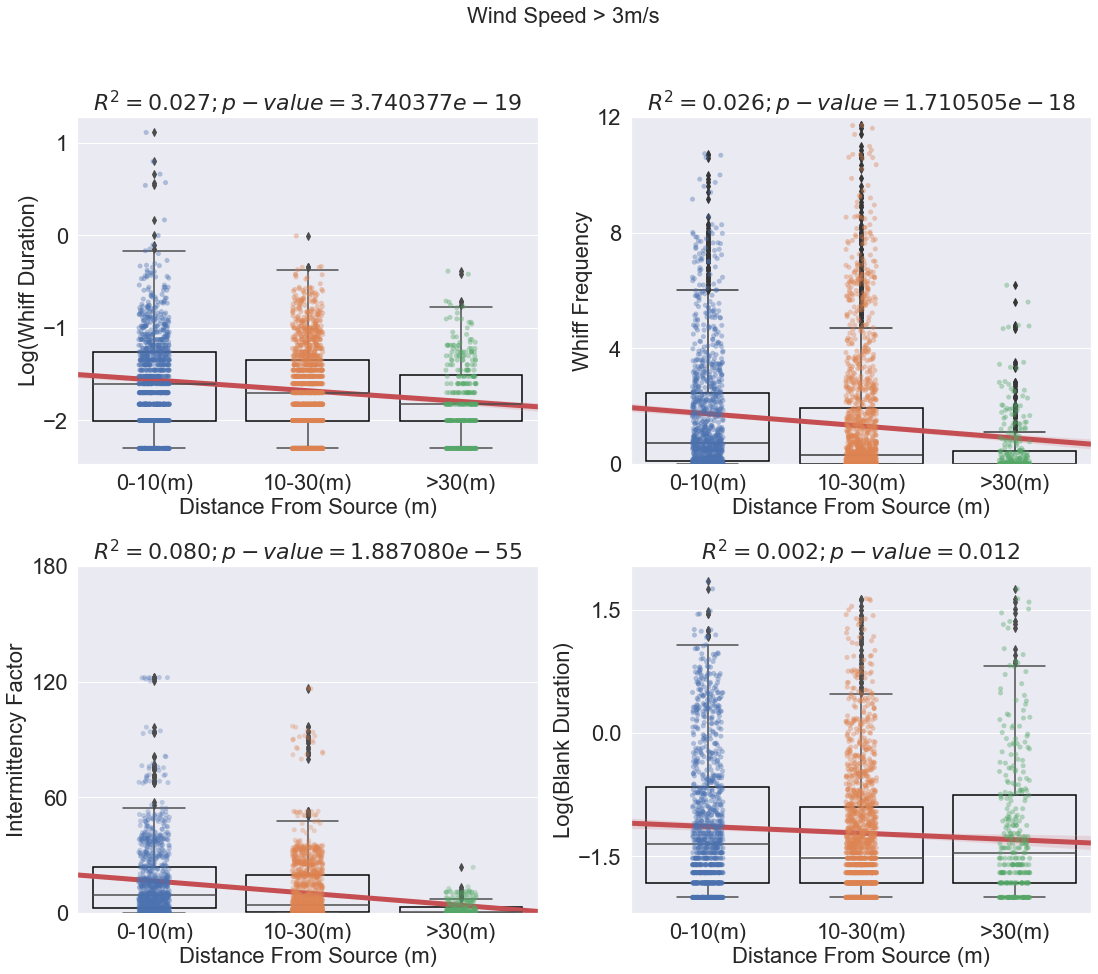

In [139]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,14)
                    ,gridspec_kw={'height_ratios':[1,1],'width_ratios': [1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )

boxplotfill(ax1)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)

sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Log(Whiff Duration)')
# ax1.title.set_text('$R^2=0.000 ; p-value=9.453134e-01$') notwindy
ax1.title.set_text('$R^2=0.027 ; p-value=3.740377e-19$')
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    

sns.stripplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)

sns.regplot(x="bins_distance",y="mean_encounter_frequency", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)


ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_ylim(0,12)
# ax2.title.set_text('$R^2=0.000 ; p-value=0.199875$')
ax2.title.set_text('$R^2=0.026 ; p-value=1.710505e-18$') 
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_intermittency_factor", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_intermittency_factor", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_intermittency_factor", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.set_ylim(0,180)
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Intermittency Factor')
# ax3.title.set_text('$R^2=0.025 ; p-value=1.447337e-21$')
ax3.title.set_text('$R^2=0.080 ; p-value=1.887080e-55$')
ax3.yaxis.set_major_locator(plt.MaxNLocator(3))

#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf,  dodge=True, ax=ax4 )
boxplotfill(ax4)
sns.regplot(x="bins_distance",y="log_blank", data=fdf, 
            ax=ax4, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)



ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Log(Blank Duration)')
# ax4.title.set_text('$R^2=0.001 ; p-value=0.134819$')
ax4.title.set_text('$R^2=0.002 ; p-value=0.012$')
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))

f.suptitle('Wind Speed > 3m/s', fontsize='large')
f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/WindyOdorStat.jpeg') 
f.savefig('../../Figure/WindyOdorStat.svg', format='svg',dpi=1200)

In [13]:
# dir = '~/Documents/Myfil|es/DataAnalysis/data/Sprints/HighRes/'
# fdf = pd.read_hdf(dir+'WindyStatswithIF.h5')

Text(0, 0.5, 'Relative Parallel Component')

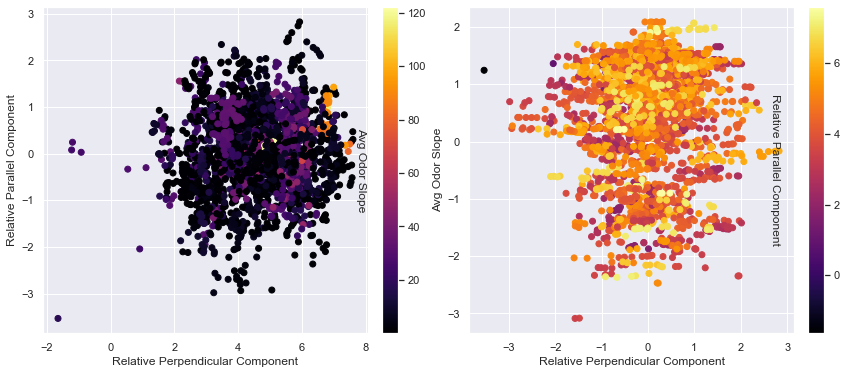

In [113]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6)) 
#                             gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})

min_val = -0.5
max_val = 2
lblpad = -60
var = ax1.scatter(fdf.avg_parallel_encounter, fdf.avg_perpendicular_encounter, 
                  c=(fdf.mean_intermittency_factor), cmap='inferno')


ax1.set_ylabel('Relative Parallel Component')
ax1.set_xlabel('Relative Perpendicular Component')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.2)
f.colorbar(var, cax=cax, orientation = 'vertical')
cax.get_yaxis().labelpad = lblpad
cax.set_ylabel('Avg Odor Slope', rotation=270)

var1 = ax2.scatter(fdf.avg_perpendicular_encounter, np.log10(fdf.mean_intermittency_factor), 
                  c=fdf.avg_parallel_encounter, cmap='inferno')


ax2.set_ylabel('Avg Odor Slope')
ax2.set_xlabel('Relative Perpendicular Component')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.2)
f.colorbar(var1, cax=cax1, orientation = 'vertical')
cax1.get_yaxis().labelpad = lblpad
cax1.set_ylabel('Relative Parallel Component', rotation=270)


# f.savefig('../../Figure/odorderiv-motioncompspeed.jpeg')

In [66]:
pd.set_option('use_inf_as_na', True) ## for excluding negative infinity and NaN values

In [149]:
encounter_freq=smf.ols(formula='np.log10(mean_encounter_frequency) ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
encounters=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
intermittencies=smf.ols(formula='log_blank ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
oderivatives = smf.ols(formula='odor_derivative ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
intermittencyfact = smf.ols(formula='mean_intermittency_factor ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()


print(intermittencyfact.summary())

                                OLS Regression Results                               
Dep. Variable:     mean_intermittency_factor   R-squared:                       0.029
Model:                                   OLS   Adj. R-squared:                  0.029
Method:                        Least Squares   F-statistic:                     44.14
Date:                       Mon, 01 Nov 2021   Prob (F-statistic):           1.29e-19
Time:                               15:18:59   Log-Likelihood:                -12392.
No. Observations:                       2941   AIC:                         2.479e+04
Df Residuals:                           2938   BIC:                         2.481e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [150]:
fdf['encounterfreq_resid']=encounter_freq.resid
fdf['encounter_resid'] = encounters.resid
fdf['intermittency_resid'] = intermittencies.resid
fdf['odorderivative_resid'] = oderivatives.resid
fdf['intermittencyfact_resid'] = intermittencyfact.resid

In [151]:
distance=smf.ols(formula='avg_dist_from_source ~ odorderivative_resid + encounter_resid + encounterfreq_resid +  intermittencyfact_resid+ intermittency_resid', data=fdf).fit()
print(distance.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(distance.summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/contwindyreg.jpeg')

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.122
Model:                              OLS   Adj. R-squared:                  0.121
Method:                   Least Squares   F-statistic:                     81.61
Date:                  Mon, 01 Nov 2021   Prob (F-statistic):           1.97e-80
Time:                          15:19:04   Log-Likelihood:                -11102.
No. Observations:                  2940   AIC:                         2.222e+04
Df Residuals:                      2934   BIC:                         2.225e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interc